In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Function Interpolation ##

We frequently want to interpolate a function which we have either analytically or (more commonly) numerically.  There are actually a very large number of ways of doing function interpolation, with different strengths and weaknesses.  In the notebook on "TableConstruction" I dealt with making polynomial and rational function approximations, including economizing power series.  Those methods are powerful.  Here we'll deal with other interpolators.

A note on nomenclature: it is becoming increasingly common to refer to function interpolators as *emulators*, which is a more statistics-y or machine learning term.  For our purposes interpolators and emulators are indistinguishable.

### Lagrange interpolating polynomial ###

Even though I promised we'd deal with other interpolators, there's one case where the dumbest [Lagrangian interpolating polynomial](https://en.wikipedia.org/wiki/Lagrange_polynomial) is almost trivial to code and works "just fine".  Suppose you had a function (which could be vector or matrix valued) of 1 parameter, $\theta$, which is pretty smooth and you have relatively few points, $\theta_i$.  A common case might be matter power spectra, or $C_\ell$, or a sky map vs. redshift or some other interesting parameter.  The Lagrange interpolant at $\theta_0$ is just a linear combination of the $f(\theta_i)$ and you can get the weights from:
$$
  L(x) = \sum_{j=0}^N y_j \ell_j(x) \qquad \textrm{with}\quad
  \ell_j(x)\equiv \prod_{i\ne j} \frac{(x-x_i)}{(x_j-x_i)}
$$
where both the numerator and denominator in $\ell_j(x)$ skip the $(x-x_j)$ or $(x_j-x_j)$ term.  For any $x$ the $\ell_j$ are just weights so you can produce an interpolation using `np.dot` on the data vector ($y_j$).

The main reason this is so useful is that in Python the $y_j$ can be very complex data types, allowing you a very fast interpolation of even 3D data cubes or other large volumes of data.

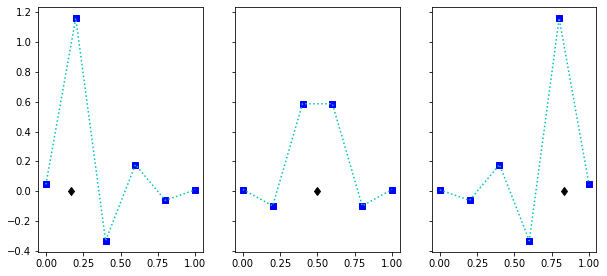

In [2]:
# Example: look at the weights for 6 points.
def lagrange_weights(theta0,theta_i):
    c = np.ones_like(theta_i)
    dt= theta_i[:,None]-theta_i[None,:]
    ss= dt==0
    dt[ss]=1.0
    wt= (theta0-theta_i)/dt
    wt[ss]=1.0
    return(wt.prod(axis=-1))
#
theta_i = np.linspace(0,1,6,endpoint=True)
#
fig,ax = plt.subplots(1,3,sharey=True,figsize=(10,4.5))
for i in range(ax.size):
    theta0 = (i+0.5)/ax.size
    wt = lagrange_weights(theta0,theta_i)
    ax[i].plot(theta_i,wt,'bs')
    ax[i].plot(theta_i,wt,'c:')
    ax[i].plot([theta0],[0.0],'kd') # Mark the theta0 point.

### Multiple dimensions ###

Polynomials have a lot of nice properties, including being easy to integrate and differentiate.  Going to multiple dimensions with polynomials is hard though because the number of coefficients to be fit explodes.  One way of handling this is known as polynomial chaos expansion.  You can find some discussion of this, as well as Python packages for implementing it at:

https://uncertainpy.readthedocs.io/en/latest/theory/pce.html

https://pypi.org/project/chaospy/

### Splines ###

Perhaps the first thing that comes to mind when you think of interpolating a function from a table is to fit a *spline*.  To a physicist the word *spline* normally means cubic interpolating spline.  This is a piecewise cubic that passes through all of the points in the table and also has continuous first and second derivatives at all points.  Such splines are highly practical because in addition to giving nice smooth functions which avoid Runge's phenomenon, the construction of the coefficients is highly efficient because it involves solving a tri-diagonal linear system.  Back-substitution allows the solution of such systems in $\mathcal{O}(N_{\rm pnt})$ time.

Still one of the best descriptions of the "standard" spline routines I know of is in Numerical Recipes.  An [online copy can be found here](http://www.aip.de/groups/soe/local/numres/bookcpdf/c3-3.pdf).

However there is a world more to splines than this "physicists' traditional spline".  You should at least be aware of the existence of:
* cubic spline a.k.a. natural spline
* [smoothing splines](https://en.wikipedia.org/wiki/Smoothing_spline) which have a nice Bayesian interpretation
* [B-spline](https://en.wikipedia.org/wiki/B-spline) and [de Boor's algorithm](https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)
* [Bezier curves](https://en.wikipedia.org/wiki/B%C3%A9zier_curve) (focus on the recursive definition, and watch the animations if you've not seen these before)
* [Hermite splines](https://en.wikipedia.org/wiki/Cubic_Hermite_spline) (which can be written as Bezier curves).
* Canonical/cardinal spline.
* Catmull-Rom spline ([Ed Catmull](https://en.wikipedia.org/wiki/Edwin_Catmull) co-founded [Pixar](https://en.wikipedia.org/wiki/Pixar)).

Smoothing splines are useful when your tabulated data have noise/scatter/errors, and you can find a nice discussion in [Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/) or various places online.  For the most common, cubic, spline it boils down to finding the function $f(x)$ with continuous 0th, 1st and 2nd derivatives that minimizes
$$
  \sum_i w_i\left[y_i-f(x_i)\right]^2 + \lambda\int dx\left[ f''(x) \right]^2
$$
When $\lambda=0$ you get a natural spline, when $\lambda\to\infty$ you get a straight line and in between you get a smooth curve passing close to the points.  Usually $\lambda$ is set by generalized cross-validation, a scheme introduced by [Craven and Wahba](https://link.springer.com/article/10.1007/BF01404567).  It turns out that $f$ can be written as a linear sum of basis functions, so minimizing the above is a linear algebra problem.  The answer is a linear combination of the $y_i$, so a regression.

Personally I think some knowledge of B-splines is pretty useful to have in understanding other algorithms though I confess I never used one specifically in any of my own work.

One thing to beware of: in SciPy the "default" spline is a smoothing spline, while if you want a physicists' spline you need to ask for an `InterpolatedUnivariateSpline`.

### Savitsky-Golay filtering ###

Before we study gaussian processes, let me mention one other means of fitting a smooth curve through some "noisy" points just because it's so easy to understand and to code -- plus it tends to work quite well: [Savitsky-Golay filtering](https://en.wikipedia.org/wiki/Savitzky–Golay_filter).  Suppose I wanted to compute a smooth curve at $x$ to some data, $y$.  The idea is to fit a low order polynomial to a small range of points near $x$ and then use the value of the polynomial at $x$.  If you work it out you'll find this procedure amounts to a weighted sum of the points around $x$ with weights given by the positions of the points and the order of the polynomial.

One place I've found this useful is dividing the matter power spectrum, including the baryon acoustic oscillations, by a "smooth/no-wiggle" function as part of a fitting procedure.  It's good for looking at trend lines in noisy time series.  There are other places it comes in useful as well.

SciPy has a Savitsky-Golay filter as part of its [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) package.

### Gaussian process interpolation ###

A G-P interpolation takes a different approach, and G-P interpolators or emulators have grown in popularity in cosmology in recent years.  While the idea is relatively straightforward, I haven't been able to find a good but concise description online so here's my attempt... you can also [take a look at this blog](https://blog.dominodatalab.com/fitting-gaussian-process-models-python/) or [this book](http://www.gaussianprocess.org/gpml/).

The mental trick to G-P emulators is to imagine that we really have a probability problem, not a curve fitting problem.  Imagine a grid of points, $y_i$, where each $y$ is to be drawn from a Gaussian with some known $\vec{\mu}$ and $C$.  For now these will be discrete, and we imagine they are the values of $y(x)$ at some specified $x_i$.  In addition suppose I told you the values of $y$ at some of the $i$s.  For simplicitly say I gave you $y_1,\cdots,y_n$ and I wanted to find $y_0$.  Very conveniently, for a Gaussian if you know $P(y_0,y_1,\cdots,y_n)$ then you can figure out $P(y_0) = P(y_0|y_1,\cdots,y_n)$.
Your best guess for $y_0$ would thus be $\langle y_0\rangle$.  So if $x_0$ lies between $x_1$ and $x_2$, say, then you have an interpolated point for $y(x)$ lying between $(x_1,y_1)$ and $(x_2,y_2)$.  In addition, you get an estimate of the uncertainty in your estimate!  In fact you get a whole PDF.

If we write
$$
  C = \left( \begin{array}{cc} C_{00} & C_{0a} \\ C_{a0} & C_{ab} \end{array} \right)
$$
with $a,b=1,\cdots,n$ then you can compute $\langle y_0\rangle$ and its error simply in terms of the components of $C$ and the known $y_i$.  In fact $\langle y_0\rangle$ is a weighted linear combination of the $y_i$ which gives higher weights to $y$'s whose points $x_i$ lie closer to $x_0$.  If you're feeling rusty on Schur decompositions and block matrix inversions, consult [the Matrix Cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf). Section 9.1.3 has the magic formulae you need for doing $C^{-1}$ for a block matrix and Section 8.1.3 discusses conditional Gaussian distributions.  There you'll find:
$$
  \left\langle y_0\right\rangle = \mu + C_{0a} C_{ab}^{-1} (y-\mu)
$$

So how does one know $\vec{\mu}$ and $C$?  It's a bit of a black art, but several functional forms are normally taken.  To begin with, you take your data $y_i$ for $i=1,\cdots,n$ and you subtract the mean and divide by the standard deviation of the points.  You typically also scale the $x_i$ to lie in the range $[0,1]$.  Then you can take $\vec{\mu}=0$.  For $C$ people try different forms.  A common one is
$$
  C_{ij}\propto \exp\left[-k\left(x_i-x_j\right)^2\right] \propto \rho^{2|x_i-x_j|^2}
$$
but you can also use exponentials or other functional forms.
You then put hyperparameters in (e.g. $k$ or $\rho$ in the 2nd form above) and you ask what is the most likely $\rho$ given the data $y_1,\cdots,y_n$?  The log-likelihood for a Gaussian is just $\ln|C|$ plus the $\chi^2$.

This is the 1D example, in terms of both the $y$ and the $x$.  Going beyond 1D in either space is just a matter of having more indices, it's no harder except for book-keeping (which means, of course, that it's **much** harder!).

#### Example ####

Let's try an example, sticking to a scalar function and one dimension.  We won't bother with optimizing the hyperparameters, though in real life that would be a large part of finding a good interpolator.


In [3]:
def Cij(xarr,sf=10.0):
    """Returns the covariance matrix: C_ij, given a 1D matrix of x-values, xarr."""
    dx = xarr[:,None]-xarr[None,:]
    return(np.exp(-sf*dx**2))
    #


def wtvec(xarr,xval):
    """Returns the weight vector to be applied to the y_i to get y(xval)
        [modulo the multiplication by sig and shift by mu].  This is just
        useful for building intuition."""
    # Note I'm putting "xval" at the end of the array, so C_{0a} is C[-1,:-1]
    # for example.
    xarr = np.append(xarr,xval)
    C    = Cij(xarr)
    Cinv = np.linalg.pinv(C[:-1,:-1])
    # The weights which give the mean value of y_0 in the 1D case.
    # Note mu=0 because we rescale the y's upon input to remove the mean.
    wtvec= np.dot(C[-1,:-1],Cinv)
    return(wtvec)
    #

    
def GP_interp(xarr,yarr,xval):
    """Does a Gaussian process interpolation."""
    xmin = np.min(xarr)
    xmax = np.max(xarr)
    xs   = np.append((xarr-xmin)/(xmax-xmin),(xval-xmin)/(xmax-xmin))
    mu   = np.mean(yarr)
    sig  = np.std(yarr)
    ys   = (yarr-mu)/sig
    C    = Cij(xs)
    Cinv = np.linalg.pinv(C[:-1,:-1])
    y0   = np.dot(np.dot(C[-1,:-1],Cinv),ys)
    y0   = sig*y0+mu
    return(y0)
    #

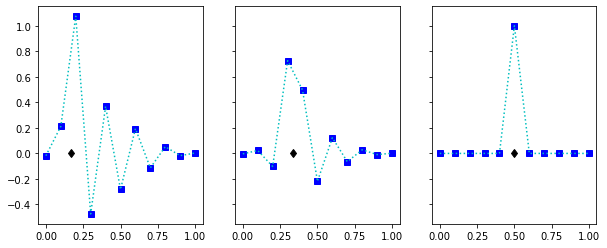

In [4]:
# G-P interpolation returns a weighted sum of the input y's.  Let's look at
# the weight vectors first!
# The faster we tell the code C drops off, the "more local" the interpolation
# will be.
xarr = np.linspace(0,1,11,endpoint=True)
xval = np.array([1./6.,1./3.,1./2.])
# Plot the weights for points at each of the xval.
# The black diamond is the point we're trying to find y(x) at.
fig,ax = plt.subplots(1,len(xval),sharey=True,figsize=(10,4))
for i,xv in enumerate(xval):
    ax[i].plot(xarr,wtvec(xarr,xv),'bs')
    ax[i].plot(xarr,wtvec(xarr,xv),'c:')
    ax[i].plot([xv],[0.0],'kd')

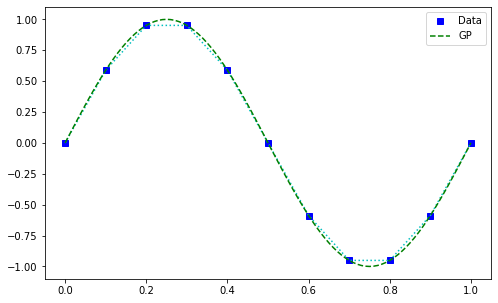

In [5]:
# Ok, now let's make up some data and interpolate it.
# For now we won't put in any noise or anything, just try
# a sine wave.
xarr = np.linspace(0,1,11,endpoint=True)
yarr = np.sin(2*np.pi*xarr)
# Now the GP interpolator at 101 points:
xv = np.linspace(0,1,101,endpoint=True)
yv = [GP_interp(xarr,yarr,x) for x in xv]
#
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(xarr,yarr,'bs',label='Data')
ax.plot(xarr,yarr,'c:')
ax.plot(xv,yv,'g--',label='GP')
ax.legend()

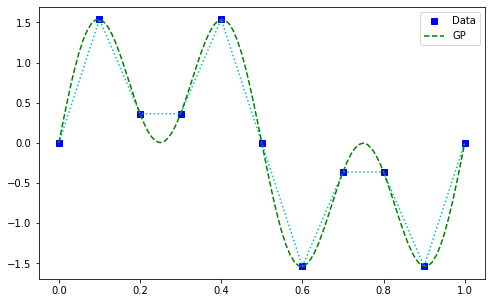

In [6]:
# That worked pretty well!
#
# What if we try something a bit more complex:
xarr = np.linspace(0,1,11,endpoint=True)
yarr = np.sin(2*np.pi*xarr) + np.sin(6*np.pi*xarr)
# Now the GP interpolator at 101 points:
xv = np.linspace(0,1,101,endpoint=True)
yv = [GP_interp(xarr,yarr,x) for x in xv]
#
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(xarr,yarr,'bs',label='Data')
ax.plot(xarr,yarr,'c:')
ax.plot(xv,yv,'g--',label='GP')
ax.legend()

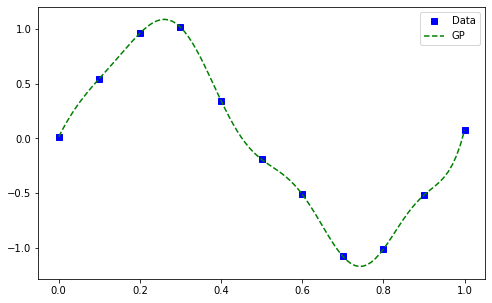

In [7]:
# What if we add some noise?
xarr = np.linspace(0,1,11,endpoint=True)
yarr = np.sin(2*np.pi*xarr) + 0.1*np.random.normal(size=xarr.size)
# Now the GP interpolator at 101 points:
xv = np.linspace(0,1,101,endpoint=True)
yv = [GP_interp(xarr,yarr,x) for x in xv]
#
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(xarr,yarr,'bs',label='Data')
ax.plot(xv,yv,'g--',label='GP')
ax.legend()

How about if we try to optimize the "hyper-parameters" describing our (assumed) covariance matrix?  Sticking with the Gaussian form for $C$ let's take $C_{ij}\propto \theta_0\exp\left[-\theta_1\left(x_i-x_j\right)^2\right]$.  Given the data $y_a$ ($a=1,\cdots,N$) the log-likelihood is
$$
  -2\ln L = \ln|C| + (y-\mu)^T C^{-1} (y-\mu)
$$
What if we try to maximize $\ln L$ with respect to $\vec{\theta}$?

This is numerically a bit tricky once the number of data points becomes large because the $C$ matrix becomes large and inversions and determinants become numerically difficult.  Rather than invest some time in doing the linear algebra "sensibly" let's just run a smaller case!

(Note, at this point we should probably have put all of this information into a class, so we're not continually rescaling the input values and recomputing things that don't change.  None of our models are that complex, so we'll just brute force.)

In [8]:
# Same model as before, but only 9 points.
xarr = np.linspace(0,1,9,endpoint=True)
yarr = np.sin(2*np.pi*xarr) + 0.20*np.random.normal(size=xarr.size)

def Cij(xarr,theta):
    """Returns the covariance matrix: C_ij, given a 1D matrix of x-values, xarr."""
    dx = xarr[:,None]-xarr[None,:]
    return(theta[0]*np.exp(-theta[1]*dx**2))
    #

    
def logLike(xarr,yarr,theta):
    """Compute the log-likelihood of the data, given theta."""
    # Convert the x's into [0,1] and the y's to mean 0 and unit variance.
    xmin = np.min(xarr)
    xmax = np.max(xarr)
    xs   = (xarr-xmin)/(xmax-xmin)
    mu   = np.mean(yarr)
    sig  = np.std(yarr)
    ys   = (yarr-mu)/sig
    # Compute C and C^{-1}
    C    = Cij(xs,theta)
    Cinv = np.linalg.pinv(C)
    detC = np.linalg.det(C)
    chi2 = np.dot(ys,np.dot(Cinv,ys))
    lnL  = -0.5*( np.log(detC) + chi2 )
    return(lnL)
    #

Text(0, 0.5, '$L$')

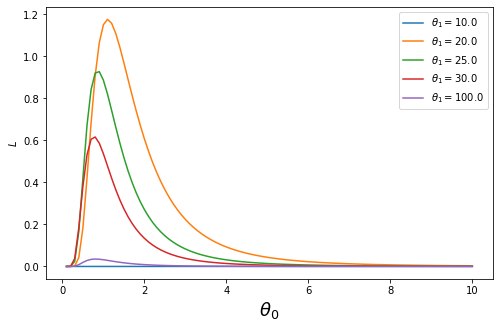

In [9]:
# Let's just plot lnL vs. theta[0] for various theta[1] values.
fig,ax = plt.subplots(1,1,figsize=(8,5))
for t1 in [10.0,20.0,25.0,30.0,100.0]:
    tt = np.linspace(0.1,10.,100)
    lL = np.array([ logLike(xarr,yarr,[t0,t1]) for t0 in tt ])
    LL = np.exp(lL)
    ax.plot(tt,LL,label="$\\theta_1={:.1f}$".format(t1))
ax.legend()
ax.set_xlabel(r'$\theta_0$',fontsize=18)
ax.set_ylabel(r'$L$')

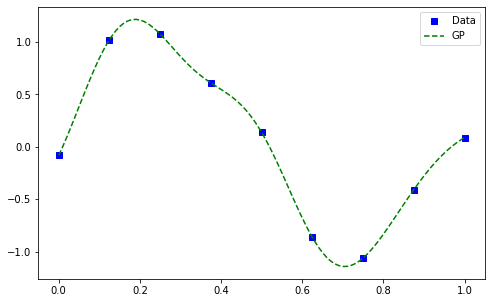

In [10]:
# So the peak is somewhere around [1,25].  We won't need it much
# more accurately than this.  Let's just hard code it for now.

def Cij(xarr,theta=[1.0,25.0]):
    """Returns the covariance matrix: C_ij, given a 1D matrix of x-values, xarr."""
    dx = xarr[:,None]-xarr[None,:]
    return(theta[0]*np.exp(-theta[1]*dx**2))
    #

def GP_interp(xarr,yarr,xval):
    """Does a Gaussian process interpolation."""
    xmin = np.min(xarr)
    xmax = np.max(xarr)
    xs   = np.append((xarr-xmin)/(xmax-xmin),(xval-xmin)/(xmax-xmin))
    mu   = np.mean(yarr)
    sig  = np.std(yarr)
    ys   = (yarr-mu)/sig
    C    = Cij(xs)
    Cinv = np.linalg.pinv(C[:-1,:-1])
    y0   = np.dot(np.dot(C[-1,:-1],Cinv),ys)
    y0   = sig*y0+mu
    return(y0)
    #
# and plot it:
xv = np.linspace(0,1,101,endpoint=True)
yv = [GP_interp(xarr,yarr,x) for x in xv]
#
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(xarr,yarr,'bs',label='Data')
ax.plot(xv,yv,'g--',label='GP')
ax.legend()

So that's the basic idea behind Gaussian Process interpolation.  Note that I've just plotted the mean, but you can easily compute the 1-sigma error (or the entire distribution if you like!) on $y(x_0)$ as well.  Simple matrix algebra tells you:
$$
  \sigma_0^2 = C_{00} - C_{0a} C_{ab}^{-1} C_{b0}
$$

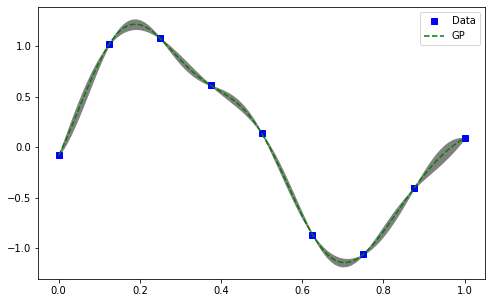

In [11]:
def GP_interp(xarr,yarr,xval):
    """Does a Gaussian process interpolation."""
    xmin = np.min(xarr)
    xmax = np.max(xarr)
    xs   = np.append((xarr-xmin)/(xmax-xmin),(xval-xmin)/(xmax-xmin))
    mu   = np.mean(yarr)
    sig  = np.std(yarr)
    ys   = (yarr-mu)/sig
    C    = Cij(xs)
    Cinv = np.linalg.pinv(C[:-1,:-1])
    y0   = np.dot(np.dot(C[-1,:-1],Cinv),ys)
    y0   = sig*y0+mu
    dy   = C[-1,-1]-np.dot(C[-1,:-1],np.dot(Cinv,C[:-1,-1]))
    dy   = np.sqrt(dy.clip(0,1e30))
    return( (y0,dy) )
    #
# Now plot it:
xv = np.linspace(0,1,101,endpoint=True)
yv = np.array([GP_interp(xarr,yarr,x) for x in xv])
#
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(xarr,yarr,'bs',label='Data')
ax.plot(xv,yv[:,0],'g--',label='GP')
ax.fill_between(xv,yv[:,0]-yv[:,1],yv[:,0]+yv[:,1],color='grey')
ax.legend()

The estimate of the error isn't actually fantastic (we'll do better below)!  The reason behind this is that we haven't tuned our $C_{ij}$ very well.  With a little work one can do a lot better than the above -- but this does get to one of the drawbacks of GP.  They're very flexible and a bit of a black box.  You need some experience picking $C_{ij}$ and making them work.  Luckily there are libraries we can use ...

### GP libraries ###

While it wasn't so hard, we normally wouldn't write our own GP code -- we would use a library.  These will have routines to optimize the hyperparameters of our $C_{ij}$ in an efficient manner.  The standard library for Gaussian process regression in Python is as part of SciKit-Learn.  You can find [an example here](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html), including an iPython notebook you can try out.

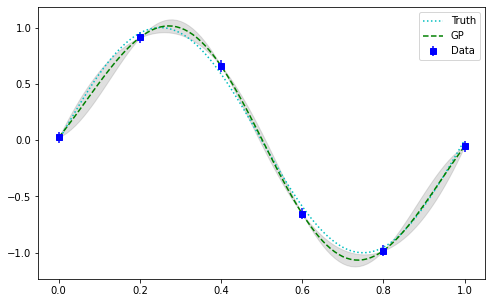

In [12]:
# An example based on the notebook referenced above.
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# Set up the data -- the regressor wants things of various dimensions
# which we need to basically fiddle here.  This is our sine wave
# example from before:
xval = np.atleast_2d(np.linspace(0,1,6,endpoint=True)).T
yval = np.sin(2*np.pi*xval).ravel() + 0.05*np.random.normal(size=6)
# Set up a kernel which is our squared-exponential form (as above)
# but now we'll optimize the hyperparameters.
kernel = C(1.0,(1e-3,1e3)) * RBF(10,(1e-2,1e2))
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=9)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(xval,yval)
# Make the prediction
xv    = np.atleast_2d(np.linspace(0,1,101)).T
y0,dy = gp.predict(xv,return_std=True)
# Plot it.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.errorbar(xval,yval,yerr=0.05,color='b',fmt='s',label='Data')
ax.plot(xv,np.sin(2*np.pi*xv),'c:',label='Truth')
ax.plot(xv,y0,'g--',label='GP')
ax.fill_between(xv.ravel(),y0-3*dy,y0+3*dy,color='grey',alpha=0.25)
ax.legend()
#
# You can run this cell multiple times to see how things change
# with different random "noise" draws for the data points.

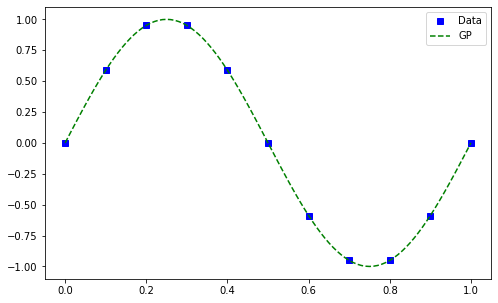

In [13]:
# It is not uncommon to want to fit scalar functions of
# a single variable, in which case the defaults tend to
# work pretty well.  Here's another way to do our sine
# wave example ...
xval = np.linspace(0,1,11,endpoint=True)
yval = np.sin(2*np.pi*xval)
#
gp = GaussianProcessRegressor(kernel=C(1.0,(1e-3,1e3))*RBF(10,(1e-2,1e2)))
gp.fit(xval.reshape(-1,1),yval)
xv = np.linspace(0,1,101)
y0 = gp.predict(xv.reshape(-1,1),return_std=False)
# Plot it.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(xval,yval,'bs',label='Data')
ax.plot(xv,y0,'g--',label='GP')
ax.legend()

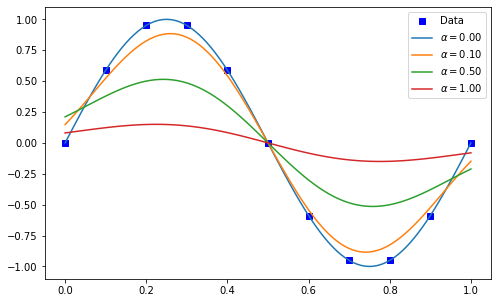

In [14]:
# Now we can also provide error bars on the points, through
# the "alpha" parameter.  These can be global or per point.
# Let's just use the global version for now.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(xval,yval,'bs',label='Data')
kernel = C(1.0,(1e-3,1e3)) * RBF(10,(1e-2,1e2))
for aa in [0.0,0.1,0.5,1.0]:
    gp = GaussianProcessRegressor(kernel=kernel,alpha=aa,n_restarts_optimizer=9)
    gp.fit(xval.reshape(-1,1),yval)
    xv = np.linspace(0,1,101)
    y0 = gp.predict(xv.reshape(-1,1),return_std=False)
    ax.plot(xv,y0,'-',label="$\\alpha={:.2f}$".format(aa))
ax.legend()
# Note the higher alpha curves tend to be "smoother", i.e.
# they penalize missing the points less.  This is another
# way to smooth a noisy data vector.

Emulators in cosmology are typically used to provide rapid predictions for the matter power spectrum, the halo mass function or other quantities estimated from expensive N-body simulations.  The first popular emulator, The Cosmic Emu, was for the (non-linear) dark matter power spectrum: [arXiv:0812.1052](https://arxiv.org/abs/0812.1052).  This has since been extended [in many different directions](http://www.hep.anl.gov/cosmology/CosmicEmu/emu.html).  You can find a version for the Ly$\alpha$ forest [here](https://arxiv.org/abs/1812.04631), which also gets into questions of experimental design (see below).

The ability to estimate error bars brings up an interesting point...

Suppose I had run a series of complex and expensive simulations or performed a set of tedious and time consuming measurements in order to determine $y(x)$ at points $x_i$.  Where would the best "next experiment" be?  The answer of course depends upon the question:

1) If I was trying for the best interpolator, I would place $x_{\rm next}$ to minimize the error on the GP interpolator.

2) If I was trying to find the maximum or minimum of a function (e.g. a likelihood or cost) I would want the point most likely to be a min-max (as determined by the interpolation and its error).  For for example, the point $x_0$ maximizing $P(y_0<{\rm min}[y_i])$.

### Experimental Design ###

The questions above go under the general rubric of ["(Bayesian) Experimental Design"](https://en.wikipedia.org/wiki/Bayesian_experimental_design), or ED.  This is a fairly well established discipline building out from a combination of experience and studies for nuclear stockpile stewardship (where tests are expensive and eventually outlawed and explosions are ... complicated).

You can get started on this by looking up "Experimental Design" and "Bayesian optimization" or taking a look at the [Dragonfly](https://github.com/dragonfly/dragonfly) Python package.  That package gives pointers about how to handle high dimensional spaces, how to do the design in parallel (say when your runs depend upon a complicated queueing system), how to mix expensive high quality and cheaper low quality measurements together and how to handle multiple "objective" functions in the optimization.

Ok, that's all good, but ...

How would you start, before you had any $x_i$ chosen?  One thing you can do is known as Latin hypercube sampling.  The basic idea is pretty simple...

Suppose I had a simple 2D parameter space.  You might think a good first choice for parameter settings would be:

Text(0, 0.5, '$\\theta_1$')

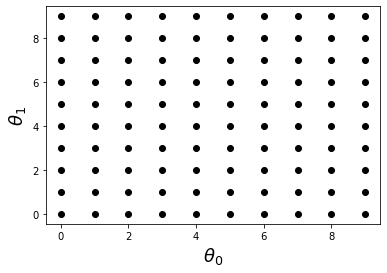

In [15]:
fig,ax = plt.subplots(1,1)
for i in range(10):
    ax.plot(np.zeros(10)+i,np.arange(10),'ko')
ax.set_xlabel(r'$\theta_0$',fontsize=18)
ax.set_ylabel(r'$\theta_1$',fontsize=18)

But this is actually a pretty terrible choice!  To see this, note that it's often the case that our function, $f(\theta_0,\theta_1)$, will depend more strongly on one of the variables than the other (or perhaps on one linear combination more strongly than the other).  Let's take the extreme example that $f(\theta_0,\theta_1)=f(\theta_0)$.  In this case you've run 100 expensive trials but you only have 10 independent $\theta_0$ values.  It would have been better to offset the higher rows ($\theta_1>0$) to sample "new" $\theta_0$ values.

You can cast this as a geometry problem, and one which has been well studied by mathematicians.  What set of $N$ points in some $M$-dimensional space is such that when you project it down to various subspaces the points don't fall on top of each other?

In general answers can be complex, but there's one simple case you probably saw in school.  A Latin square is an $N\times N$ grid containing the numbers $1,\cdots,N$ which has only 1 number in any row or column.  As long as you project parallel to the axes, no two points will overlap.  The generalization to multiple dimensions is a [Latin Hypercube](https://en.wikipedia.org/wiki/Latin_hypercube_sampling).  You can use Latin hypercubes to help you construct orthogonal arrays (also used in [software or product testing](https://en.wikipedia.org/wiki/Orthogonal_array_testing)) which allow you to project not just parallel to the axes.  This technology is pretty well developed in the applied mathematics literature, so it's just a matter of adopting their solutions.  The [PyDOE](https://pythonhosted.org/pyDOE/) software is an experimental design package for Python.

The other direction which is useful is "subrandom sequences" or ["low discrepancy sequences"](https://en.wikipedia.org/wiki/Low-discrepancy_sequence), which are frequently used in Monte-Carlo integration but can also be useful for ED.  A simple example is the sequence $s_{n+1}=(s_n+c)\ {\rm mod}\ 1$ with $c=(\sqrt{5}-1)/2$ or the square root of some prime.  In multiple dimensions just choose different values of $c$ for each dimension (e.g. $c_x=\sqrt{27}$ and $c_y=\sqrt{17}$).

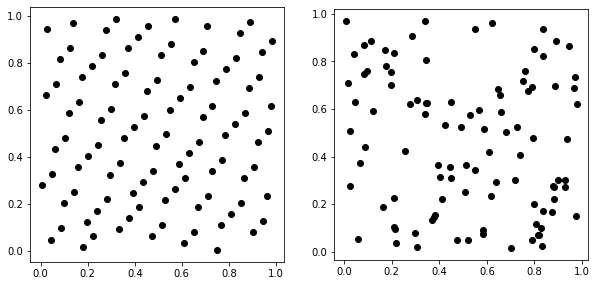

In [16]:
# A sub-random sequence.
xx,yy = [],[]
cx,cy = np.sqrt(27.0),np.sqrt(17.0)
sx,sy = 0.0,0.0
for i in range(100):
    sx,sy = sx+cx,sy+cy
    sx,sy = sx-np.floor(sx),sy-np.floor(sy)
    xx.append(sx)
    yy.append(sy)
# A random sequence.
rr = np.random.uniform(size=(100,2))
# Plot them side by side.
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(xx,yy,'ko')
ax[0].set_aspect('equal')
ax[1].plot(rr[:,0],rr[:,1],'ko')
ax[1].set_aspect('equal')
# Note the gaps and clumps in the "true" random sequence
# -- often NOT what you want.  Which is best depends upon
# your special circumstances, but the lhs is often quite good.

There are "better" methods for choosing points than this simple example, but it's already doing pretty well actually.
Going further in this direction takes us well out of the mainstream of this course!

## Noise reduction ##

Finally a note about how to handle situations where your "theory" is simulation/Monte-Carlo based.  Examples include using N-body simulations to get power spectra or end-to-end simulations of experiments, or simulations designed to calibrate a transfer function if your pipeline involves data flagging or data cuts.

Often, especially for his fidelity simulations, this process is expensive.  It can be expensive because of the huge data volume (e.g. time stream simulation) or runtime (e.g. hydrodynamic or N-body simulations).  How can we reduce the sampling noise from a finite number of simulations?

Frequently we are in a situation where we have an "approximation" to the full simulation.  This could be analytic, or we know e.g. the no-data-cuts solution or it could be a quick-and-dirty simulation.  A lot has been written about this, but there are two ideas which are so useful I include them here.

1) First is the idea (alluded to above) of mixing high and low fidelity simulations.  The basic idea is simple.  Extend your parameter space by 1, and include a "fidelity" dimension.  Imagine it runs $[0,1]$ with 0 being low fidelity and 1 being high fidelity.  Now populate your training set with a mix of high and low fidelity simulations, and interpolate (e.g. using a Gaussian process).  You want $F({\rm param},{\rm fidelity}=1)$ given a set of training points $\{\vec{p},f\}$. (Remember you can also put error bars on training points using GP which provides another way of handling this.)

2) The second trick is known as [control variates](https://en.wikipedia.org/wiki/Control_variates).  The basic idea is super clever, and very easy to remember and implement.  Suppose you are trying to estimate $\langle x\rangle$ from a set of samples, but they are expensive to produce.  However it is easy to produce approximations, $y$.  Since I can produce many $y$s I can measure $\mu_y=\langle y\rangle$ with little error. Define
$$
  z = x + c(y-\mu_y)
$$
for $c$ to be determined.  Clearly $\langle z\rangle = \langle x \rangle$ for any $c$.  Simply adjust $c$ to reduce the variance in $z$, so that a small number of samples of $z$ accurately predicts $\langle x\rangle$!  Not surprisingly the solution is minus the covariance of $x$ and $y$ divided by the variance of $y$.  One example of this is to run a few expensive N-body simulations.  Then from the same ICs run some quick approximations so you know $y$ for each $x$ and hence an estimate of $\langle xy\rangle$.  Also run several thousand approximations to estimate $\mu_y$.  Now for each of your limited number of simulations $x$ compute $z$ and average to get $\langle z\rangle$ which is a better estimate of $\langle x\rangle$ than the original simulations were. Of course they don't need to be N-body simulations, you would be in the same situation with timestream simulations for example or simulations of astrophysical foregrounds, or ...

## Exercise ##

Let's finish up with an exercise for you!  Use the SciKit.Learn GP interpolator to make an emulator for the halo mass function.  In reality this would require you running many, many expensive N-body simulations, finding dark matter halos in them and then finding a fitting function for the results as a function of cosmological parameters and possibly other settings.  We'll take a short-cut.

Let us make some simplifying assumptions which make the halo mass function an analytic function of 2 variables, and then you'll come up with an interpolator for that.  You can then easily study how your interpolator behaves as you change the sampling of the training sample, methods for "flattening" the output etc.  Specifically we're going to assume that $\Omega_m=1$ and the halo mass function is given by the Press-Schechter expression
$$
  \frac{dn}{dM} = \frac{\bar{\rho}}{M}\sqrt{\frac{2}{\pi}}\ \frac{\delta_c}{\sigma^2}
  \ \frac{d\sigma}{dM}\exp\left[-\frac{\delta_c^2}{2\sigma^2}\right]
$$
with $\delta_c\simeq 1.686$ and $\sigma=\sigma(M,z)$.  Normally we would obtain $\sigma(M,z)$ as an integral over the linear theory, matter power spectrum.  However if our power spectrum happened to be a power law, $P(k)\propto k^n$, then
$$
  \sigma^2(M) = \int\frac{dk}{k}\Delta^2_{\rm lin}(k,z)W^2(k,R) \propto M^{-(3+n)/3}
  \quad , \quad
  M = \frac{4\pi}{3}\bar{\rho}R^2
$$
To make life easy define $M_\star$ so that $\sigma(M_\star)=\delta_c$ at $z=0$ so that
$$
  \nu(M) = \left[\frac{\delta_c}{\sigma}\right]^2 = \left[\frac{M}{M_\star}\right]^{(n+3)/3}
  \qquad \mathrm{Note:\ square!}
$$
Beware I'm using $\nu$ but this is the peak height *squared*.  So this allows us to compute $dn/dM$ given $M_\star$.  But we also know that $\sigma^2\propto a^2$ for an EdS model so $\sigma\propto(1+z)^{-1}$.

Once you pick one normalization ($M_\star$ at $z=0$) you have $dn/dM$ as a function of $M$ at any $z$.  Code up an interpolator for $dn/dM$ which returns $dn/dM$ for a given $(M,z)$ pair.  How well does it do?  Where does it perform least well?  How many "training simulations" did you need?